In [1]:
import findspark
findspark.init()

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.tree import RandomForest, RandomForestModel

### Cover Type

Classify geographical locations according to their predicted tree cover:

* **URL:** http://archive.ics.uci.edu/ml/datasets/Covertype
* **Abstract:** Forest CoverType dataset
* **Data Set Description:** http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info

In [2]:
#define a dictionary of cover types
CoverTypes={1.0: 'Spruce/Fir',
            2.0: 'Lodgepole Pine',
            3.0: 'Ponderosa Pine',
            4.0: 'Cottonwood/Willow',
            5.0: 'Aspen',
            6.0: 'Douglas-fir',
            7.0: 'Krummholz' }
print 'Tree Cover Types:'
CoverTypes

Tree Cover Types:


{1.0: 'Spruce/Fir',
 2.0: 'Lodgepole Pine',
 3.0: 'Ponderosa Pine',
 4.0: 'Cottonwood/Willow',
 5.0: 'Aspen',
 6.0: 'Douglas-fir',
 7.0: 'Krummholz'}

In [3]:
# creating a directory called covtype, download and decompress covtype.data.gz into it

from os.path import exists
if not exists('covtype'):
    print "creating directory covtype"
    !mkdir covtype
%cd covtype
if not exists('covtype.data'):
    if not exists('covtype.data.gz'):
        print 'downloading covtype.data.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
    print 'decompressing covtype.data.gz'
    !gunzip -f covtype.data.gz
!ls -l
%cd ..

/CSE255-DSE230/Classes/HW-7/covtype
total 73408
-rw-r--r-- 1 root root 75169317 May 30 07:02 covtype.data
/CSE255-DSE230/Classes/HW-7


In [4]:
# Define the feature names
cols_txt="""
Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology,
Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways,
Hillshade_9am, Hillshade_Noon, Hillshade_3pm,
Horizontal_Distance_To_Fire_Points, Wilderness_Area (4 binarycolumns), 
Soil_Type (40 binary columns), Cover_Type
"""

In [5]:
# Break up features that are made out of several binary features.
from string import split,strip
cols=[strip(a) for a in split(cols_txt,',')]
colDict={a:[a] for a in cols}
colDict['Soil_Type (40 binary columns)'] = ['ST_'+str(i) for i in range(40)]
colDict['Wilderness_Area (4 binarycolumns)'] = ['WA_'+str(i) for i in range(4)]
Columns=[]
for item in cols:
    Columns=Columns+colDict[item]
print Columns

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WA_0', 'WA_1', 'WA_2', 'WA_3', 'ST_0', 'ST_1', 'ST_2', 'ST_3', 'ST_4', 'ST_5', 'ST_6', 'ST_7', 'ST_8', 'ST_9', 'ST_10', 'ST_11', 'ST_12', 'ST_13', 'ST_14', 'ST_15', 'ST_16', 'ST_17', 'ST_18', 'ST_19', 'ST_20', 'ST_21', 'ST_22', 'ST_23', 'ST_24', 'ST_25', 'ST_26', 'ST_27', 'ST_28', 'ST_29', 'ST_30', 'ST_31', 'ST_32', 'ST_33', 'ST_34', 'ST_35', 'ST_36', 'ST_37', 'ST_38', 'ST_39', 'Cover_Type']


In [6]:
# Have a look at the first two lines of the data file
!head -2 covtype/covtype.data

2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [7]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
from pyspark import SparkContext
sc = SparkContext()

path='covtype/covtype.data'
inputRDD=sc.textFile(path)
inputRDD.take(3)

[u'2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5',
 u'2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5',
 u'2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2']

In [8]:
# Transform the text RDD into an RDD of LabeledPoints

def transform_input(input_x):
    return LabeledPoint(input_x[-1], input_x[:-1])
    
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')]).map(lambda x: transform_input(x))
Data.first()


LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])

In [9]:
# count the number of examples of each type
total=Data.cache().count()
print 'total data size=',total
counts=Data.map(lambda x: (x.label, 1)).reduceByKey(lambda x,y: x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
print '              type (label):   percent of total'
print '---------------------------------------------------------'
print '\n'.join(['%20s (%3.1f):\t%4.2f'%(CoverTypes[a[0]],a[0],100.0*a[1]/float(total)) for a in counts])

total data size= 581012
              type (label):   percent of total
---------------------------------------------------------
      Lodgepole Pine (2.0):	48.76
          Spruce/Fir (1.0):	36.46
      Ponderosa Pine (3.0):	6.15
           Krummholz (7.0):	3.53
         Douglas-fir (6.0):	2.99
               Aspen (5.0):	1.63
   Cottonwood/Willow (4.0):	0.47


### Making the problem binary

The implementation of BoostedGradientTrees in MLLib supports only binary problems. the `CovTYpe` problem has
7 classes. To make the problem binary we choose the `Lodgepole Pine` (label = 2.0). We therefor transform the dataset to a new dataset where the label is `1.0` is the class is `Lodgepole Pine` and is `0.0` otherwise.

In [10]:
Label=2.0
def convert_type(value):
    if value[-1] == Label:
        return LabeledPoint(1.0, value[:-1])
    else:
        return LabeledPoint(0.0, value[:-1])

Data=inputRDD.map(lambda line: [float(x) for x in line.split(',')]).map(lambda V: convert_type(V))
Data

PythonRDD[11] at RDD at PythonRDD.scala:48

### Reducing data size
In order to see the effects of overfitting more clearly, we reduce the size of the data by a factor of 10

In [11]:
Data1=Data.sample(False,0.1).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=58492, trainingData=40852, testData=17640


In [12]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(0.0, 9072), (1.0, 8568)]

### Gradient Boosted Trees

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts) from the mllib documentation

* [pyspark.mllib.tree.GradientBoostedTrees documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.GradientBoostedTrees)

#### Main classes and methods

* `GradientBoostedTrees` is the class that implements the learning trainClassifier,
   * It's main method is `trainClassifier(trainingData)` which takes as input a training set and generates an instance of `GradientBoostedTreesModel`
   * The main parameter from train Classifier are:
      * **data** – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1}.
      * categoricalFeaturesInfo – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
      * **loss** – Loss function used for minimization during gradient boosting. Supported: {“logLoss” (default), “leastSquaresError”, “leastAbsoluteError”}.
      * **numIterations** – Number of iterations of boosting. (default: 100)
      * **learningRate** – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
      * **maxDepth** – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 3)
      * **maxBins** – maximum number of bins used for splitting features (default: 32) DecisionTree requires maxBins >= max categories
      
      
* `GradientBoostedTreesModel` represents the output of the boosting process: a linear combination of classification trees. The methods supported by this class are:
   * `save(sc, path)` : save the tree to a given filename, sc is the Spark Context.
   * `load(sc,path)` : The counterpart to save - load classifier from file.
   * `predict(X)` : predict on a single datapoint (the `.features` field of a `LabeledPont`) or an RDD of datapoints.
   * `toDebugString()` : print the classifier in a human readable format.

In [21]:
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,
                                               categoricalFeaturesInfo={}, maxDepth=depth,
                                               loss='leastAbsoluteError')
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.2750566893424036, 'train': 0.26926466268481347} 142 seconds
3 {'test': 0.26099773242630386, 'train': 0.25514050719671005} 162 seconds
6 {'test': 0.20980725623582766, 'train': 0.19910897875257025} 253 seconds
10 {'test': 0.15107709750566894, 'train': 0.1004112405757368} 756 seconds
{1: {'test': 0.2750566893424036, 'train': 0.26926466268481347}, 10: {'test': 0.15107709750566894, 'train': 0.1004112405757368}, 3: {'test': 0.26099773242630386, 'train': 0.25514050719671005}, 6: {'test': 0.20980725623582766, 'train': 0.19910897875257025}}


In [22]:
B10 = errors

Populating the interactive namespace from numpy and matplotlib


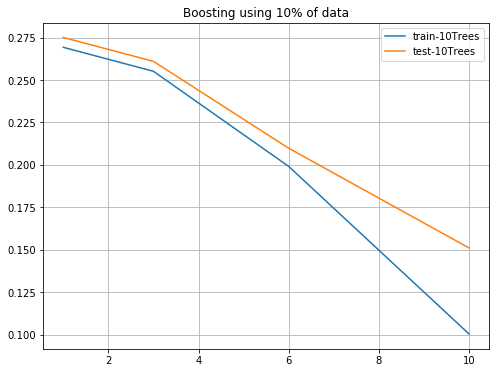

In [23]:
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

### Random Forests

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#classification) from the mllib documentation

* [pyspark.mllib.trees.RandomForest documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.RandomForest)

**trainClassifier**`(data, numClasses, categoricalFeaturesInfo, numTrees, featureSubsetStrategy='auto', impurity='gini', maxDepth=4, maxBins=32, seed=None)`   
Method to train a decision tree model for binary or multiclass classification.

**Parameters:**  
* *data* – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1, ..., numClasses-1}.  
* *numClasses* – number of classes for classification.  
* *categoricalFeaturesInfo* – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.  
* *numTrees* – Number of trees in the random forest.  
* *featureSubsetStrategy* – Number of features to consider for splits at each node. Supported: “auto” (default), “all”, “sqrt”, “log2”, “onethird”. If “auto” is set, this parameter is set based on numTrees: if numTrees == 1, set to “all”; if numTrees > 1 (forest) set to “sqrt”.
* *impurity* – Criterion used for information gain calculation. Supported values: “gini” (recommended) or “entropy”.  
* *maxDepth* – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 4)  
* *maxBins* – maximum number of bins used for splitting features (default: 32)
* *seed* – Random seed for bootstrapping and choosing feature subsets.  

**Returns:**	
RandomForestModel that can be used for prediction

In [25]:
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                         numTrees=10, featureSubsetStrategy="auto",
                                         impurity='gini', maxDepth=depth, maxBins=32)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        ### FILLIN ###
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.3380952380952381, 'train': 0.33153823558210127} 6 seconds
3 {'test': 0.26632653061224487, 'train': 0.2633408401057476} 5 seconds
6 {'test': 0.2506235827664399, 'train': 0.24667090962498775} 9 seconds
10 {'test': 0.27465986394557823, 'train': 0.2694604915304024} 7 seconds
{1: {'test': 0.3380952380952381, 'train': 0.33153823558210127}, 10: {'test': 0.27465986394557823, 'train': 0.2694604915304024}, 3: {'test': 0.26632653061224487, 'train': 0.2633408401057476}, 6: {'test': 0.2506235827664399, 'train': 0.24667090962498775}}


Populating the interactive namespace from numpy and matplotlib


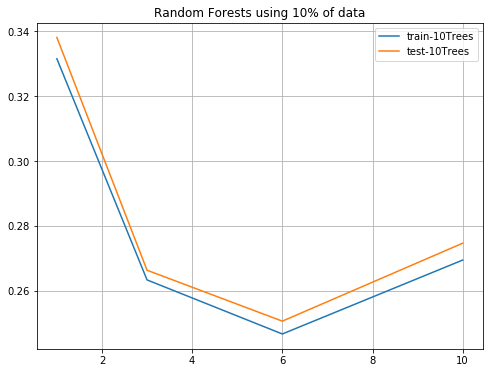

In [26]:
%pylab inline
from plot_utils import *
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')

### Now plot B10 and RF_10trees performance curves in the same graph

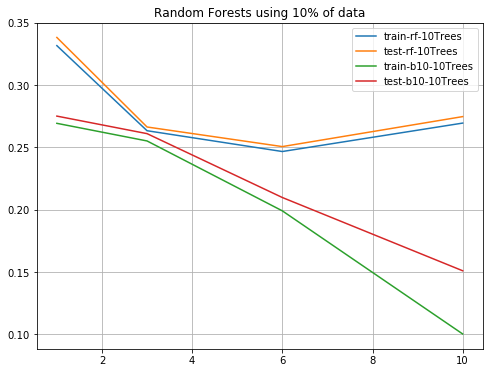

In [27]:
make_figure([RF_10trees, B10],['rf-10Trees', 'b10-10Trees'],Title='Random Forests using 10% of data')